### Graph Convolutional Network


In [19]:
import torch
from torch_geometric.nn import GCNConv
import numpy as np
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data  # da rivedere
from torch_geometric.loader import DataLoader #da rivedere
from modules.graph import get_similarity_graph
import pandas as pd
from torchmetrics import Accuracy, F1Score, Precision, Recall
from typing import Literal
from modules import graph, dataset
import torch.nn.functional as F



TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

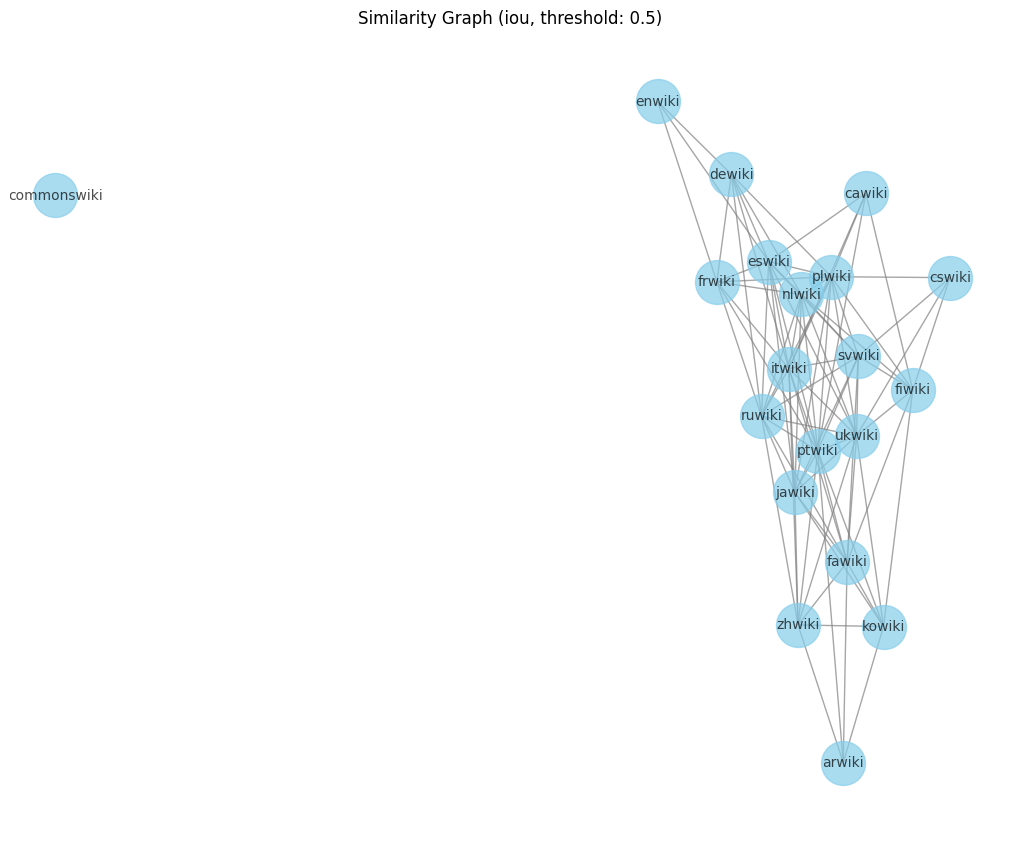

In [ ]:
train_set: pd.DataFrame = dataset.prepare_dataset('train')
train_x: pd.DataFrame = train_set.drop(columns=['label']).sample(frac=1, random_state=42)
train_y: pd.Series = train_set['label']

mode: Literal['iou', 'correlation', 'filtered correlation'] = 'iou'
treshold: float = 0.5
G_train: nx.Graph = graph.get_similarity_graph(train_x, similarity_threshold=treshold, mode=mode, save_fig=True)
data_train: Data = from_networkx(G_train)


val_set=dataset.prepare_dataset('valid')
val_x: pd.DataFrame = val_set.drop(columns=['label']).sample(frac=1, random_state=42)
val_y: pd.Series = val_set['label']

G_val: nx.Graph = graph.get_similarity_graph(val_x, similarity_threshold=treshold, mode=mode, save_fig=True)
data_val: Data = from_networkx(G_val)


In [21]:
class create_model(pl.LightningModule):
    def __init__(self, input_feature, hidden_feature, output_feature, lr, dropout):
        super().__init__()
        self.conv1 = GCNConv(input_feature, hidden_feature)
        self.fc = nn.Linear(hidden_feature, hidden_feature)
        self.conv2 = GCNConv(hidden_feature, output_feature)
        self.dropout = dropout
        self.lr = lr
        self.loss = torch.nn.CrossEntropyLoss()
        self.val_acc = Accuracy(task="multiclass", num_classes=3)
        self.f1 = F1Score(task="multiclass", num_classes=3)
        self.val_precision = Precision(task="multiclass", num_classes=3)
        self.val_recall = Recall(task="multiclass", num_classes=3)


    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)                 
        x = F.relu(x)
        x = F.dropout(x,self.dropout, train=self.training)
        x = self.fc(x)
        x = F.softmax(x, dim=1)
        return x
    
    def training_step(self, batch, batch_idx):
        output = self(batch.x, batch.edge_index)
        loss = self.loss(output[batch.train_mask], batch.y[batch.train_mask])
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        output = self(batch.x, batch.edge_index)
        prediction = output.argmax(dim=1)
        y_true = batch.y[batch.val_mask]
        y_pred = prediction[batch.val_mask]
        
        acc = self.val_acc(y_pred, y_true)
        f1 = self.f1(y_pred, y_true)
        prec = self.val_precision(y_pred, y_true)
        recall = self.val_recall(y_pred, y_true)
        return acc, f1 , prec, recall
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [22]:
train_loader = DataLoader([data_train], batch_size=1)
val_loader = DataLoader([data_val], batch_size=1)

model = create_model(
    input_feature= len(train_x.columns),
    hidden_feature= 64,
    output_feature=3,
    lr=0.01,
    dropout=0.5
)

trainer = pl.Trainer(
    max_epochs=100,
    log_every_n_steps=1  # per log più frequenti (anche con 1 batch)
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)



You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type                | Params | Mode 
--------------------------------------------------------------
0 | conv1         | GCNConv             | 1.3 K  | train
1 | fc            | Linear              | 4.2 K  | train
2 | conv2         | GCNConv             | 195    | train
3 | loss          | CrossEntropyLoss    | 0      | train
4 | val_acc       | MulticlassAccuracy  | 0      | train
5 | f1            | MulticlassF1Score   | 0      | train
6 | val_precision | MulticlassPrecision | 0      | train
7 | val_recall    | MulticlassRecall    | 0      | train
--------------------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model par

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\fedur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


AttributeError: 'NoneType' object has no attribute 'size'